## Import Dependencies

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

In [18]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

##

## Creating Variational Autoencoder Architecture

In [19]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size= 3, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size= 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Bottleneck Layer
        self.bottleneck_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64 * 14 * 14, out_features=32),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=32, out_features=latent_dim) # Used for mu and sigma
        )

        # Need to reshape before passing to decoder layer
        self.decoder_input = nn.Linear(in_features=latent_dim, out_features=64 * 28 * 28 * 1)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        )


    def forward(self, x):
        encoded = self.encoder(x)
        conv_shape = encoded.shape
        # print(conv_shape)
        mu = self.bottleneck_layer(encoded)
        sigma = self.bottleneck_layer(encoded)
        epsilon = torch.randn_like(sigma)

        z_new = mu + torch.exp(sigma/2) * epsilon

        z_new = self.decoder_input(z_new)
        # print(z_new.shape)
        z_new = torch.reshape(z_new, (-1, 64, 28, 28))

        reconstruction = self.decoder(z_new)
        reconstruction = torch.sigmoid(reconstruction)
        # print(reconstruction.shape)

        return reconstruction, mu, sigma

In [20]:
# Test Model on Random Image
# random_image = torch.randn((32, 1, 28,28))
# model = VAE(20)
# model(random_image)

In [21]:
# Initialize the model
latent_dim = 20
model = VAE(latent_dim).to(device)

## Loading in the MNIST Dataset

In [22]:
# Loading the Dataset
batch_size = 32
dataset = datasets.MNIST(root = "dataset/", train = True, transform = transforms.ToTensor(), download = True)
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

## Custom Loss and Optimizer

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [24]:
# Custom Loss Function
class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z_decoded, x, sigma, mu):
        recon_loss = nn.functional.binary_cross_entropy(z_decoded, x)
        kl_loss = -5e-4 * torch.mean(1 + sigma - torch.square(mu) - torch.exp(sigma), axis = 1)
        total_loss = torch.mean(recon_loss + kl_loss)
        return total_loss

In [25]:
# Test the loss function
# random_image_1 = torch.rand((1,28,28))
# random_image_2 = torch.rand((1, 28, 28))
# mu = torch.abs(torch.randn((64,2)))
# sigma = torch.abs(torch.randn((64,2)))
# vae_loss = VAELoss()
# vae_loss(random_image_1, random_image_2, sigma, mu)

In [26]:
# Initialize the Loss Function
loss_fn = VAELoss()

## Training Step

In [27]:
def train_step(model, epochs, loss_fn, optimizer, train_dataloader):
    history = {
        "loss" : []
    }
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (X, _) in loop:
            X = X.to(device)

            # Get reconstructed image, mu, and sigma
            reconstruction, mu, sigma = model(X)

            # Calculate the loss
            loss = loss_fn(reconstruction, X, sigma, mu)
            total_loss += loss

            # Optimizer zero gradient
            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            # Gradient Descent Step
            optimizer.step()

            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss = loss.item())

        total_loss /= len(train_dataloader)
        history["loss"].append(loss)

        print(f"Epoch: [{epoch+1}/{epochs}] | Loss: {total_loss}")

    return history

In [28]:
EPOCHS = 10
history = train_step(model, EPOCHS, loss_fn, optimizer, train_dataloader)

Epoch: [1/10] | Loss: 0.20592094957828522


Epoch: [2/10] | Loss: 0.18130046129226685


Epoch: [3/10] | Loss: 0.1756586879491806


Epoch: [4/10] | Loss: 0.17231613397598267


Epoch: [5/10] | Loss: 0.170134037733078


Epoch: [6/10] | Loss: 0.1684555858373642


Epoch: [7/10] | Loss: 0.16704685986042023


Epoch: [8/10] | Loss: 0.16586823761463165


Epoch: [9/10] | Loss: 0.16494788229465485


Epoch: [10/10] | Loss: 0.1641247421503067


## Making Inferences

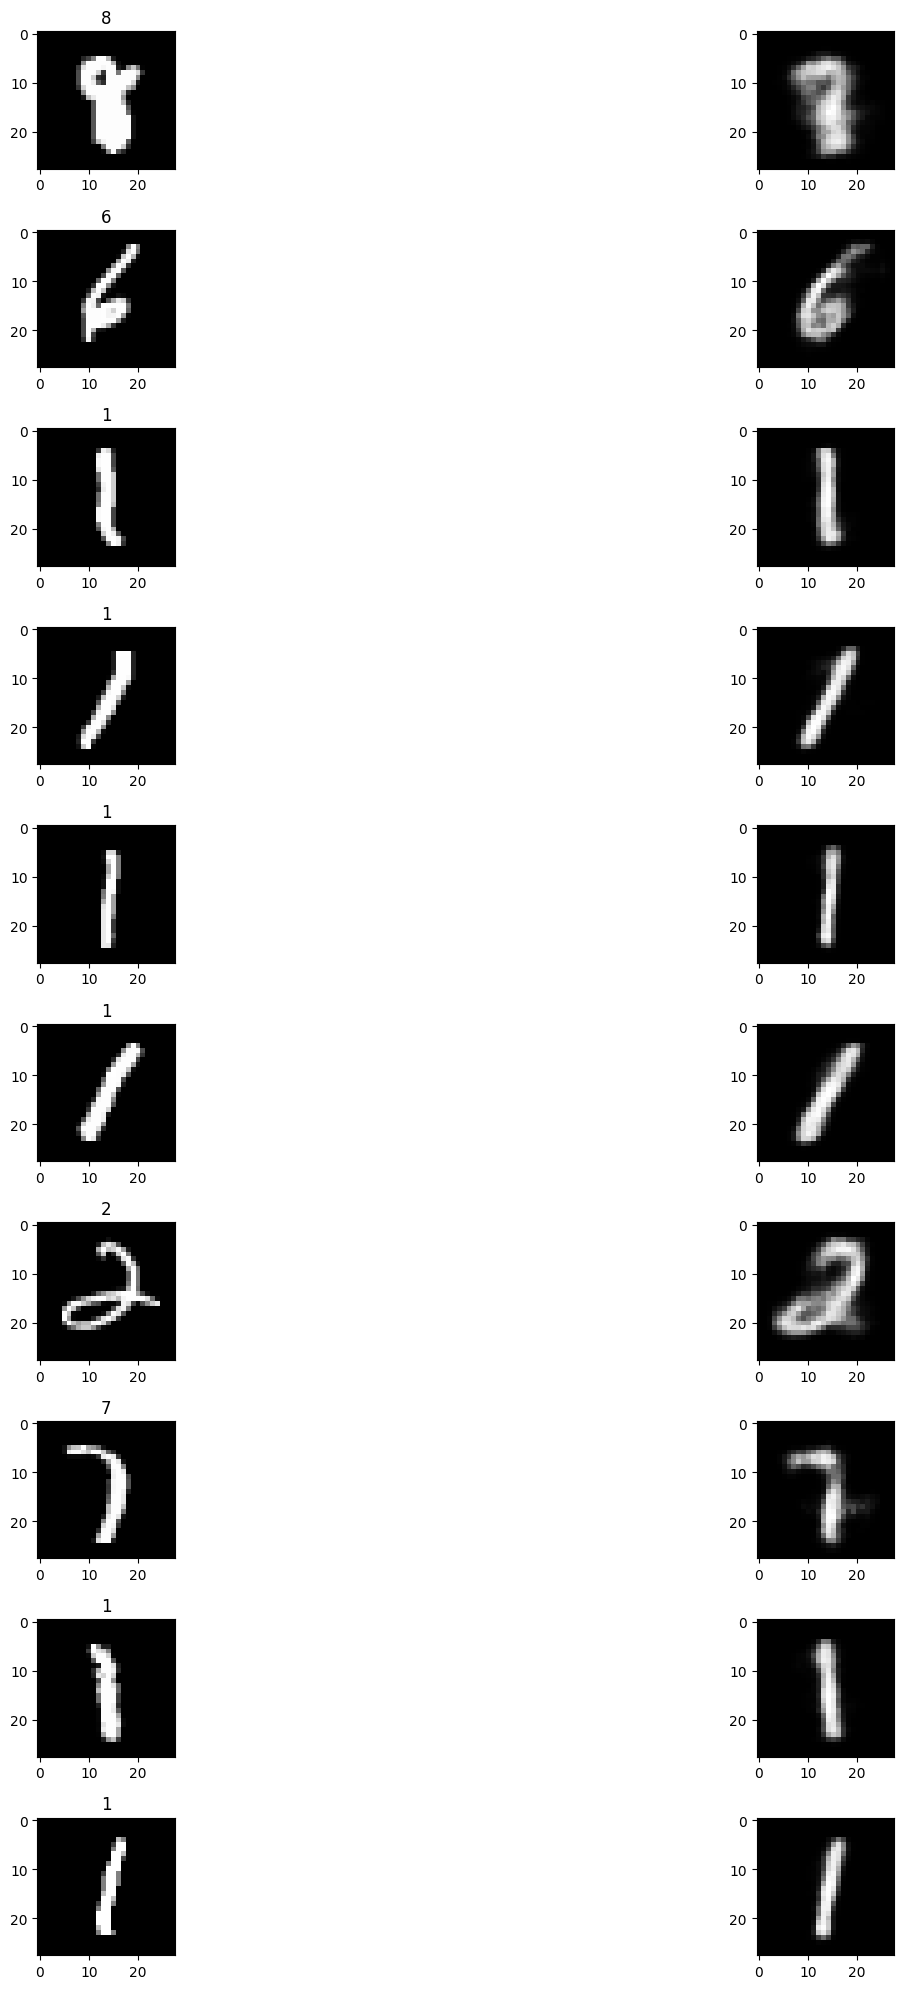

In [29]:
model = model.to("cpu")
model.eval()
with torch.inference_mode():
  image, label = next(iter(train_dataloader))
  generated_image, _, _ = model(image)
  fig, axes = plt.subplots(10, 2, figsize = (20,20))
  for i in range(10):
    index = random.randint(0, batch_size-1)
    axes[i,0].imshow(torch.permute(image[index], [1, 2, 0]), cmap = "gray")
    axes[i,0].set_title(label[index].item())
    axes[i,1].imshow(torch.permute(generated_image[index], [1, 2, 0]), cmap = "gray")
  plt.tight_layout()
  plt.show()